## Code to interpolate ERA5 fields to nested WRF domain

#### Loading Python modules:

In [1]:
import numpy as np
import numpy 
from netCDF4 import Dataset
import csv
import glob 
import xarray as xr
import matplotlib
import matplotlib.pyplot as plt
import os
from mpl_toolkits.basemap import Basemap
from scipy.ndimage.filters import gaussian_filter
from wrf import ALL_TIMES
from wrf import (to_np, getvar, smooth2d, get_cartopy, cartopy_xlim,
cartopy_ylim, latlon_coords)
from wrf import getvar, interplevel, interpz3d
import matplotlib.colors as mcolors
import pygrib
import cfgrib
from datetime import datetime
from datetime import datetime, timedelta
from scipy.interpolate import griddata
import pickle

/perm/bidc/conda/envs/Emmanouil_Project/lib/python3.8/site-packages/gribapi/__init__.py:23: UserWarning: ecCodes 2.31.0 or higher is recommended. You are running version 2.26.0
  warnings.warn(


#### Defining some functions:

#### Defining function to obtain initial and end date for each cyclone:

In [2]:
def get_cyclone_dates(folder_wrf_path, cyc_num):
    
    # Listing sorted WRF files:
    file_name_d01 = folder_wrf_path+'medCYC_{:04d}_d01*_00_00'.format(cyc_num)
    file_name_d02 = folder_wrf_path+'medCYC_{:04d}_d02*_00_00'.format(cyc_num)
    files_d01 = np.sort(glob.glob(file_name_d01))
    files_d02 = np.sort(glob.glob(file_name_d02))
    
    # Initialize variables to store the earliest and latest dates
    earliest_date = None
    latest_date = None

    # Loop through the filenames
    for file_name in files_d02:
        # Extract the date part from the filename
        parts = file_name.split('_')
        date_str = parts[4] + ' ' + parts[5]  + parts[6] + parts[7] # Combine date and time parts
        # Convert the string to a datetime object
        date = datetime.strptime(date_str, '%Y-%m-%d %H%M%S')

        # Update earliest and latest dates
        if earliest_date is None or date < earliest_date:
            earliest_date = date
        if latest_date is None or date > latest_date:
            latest_date = date

    # Print the results
    print("Earliest date:", earliest_date)
    print("Latest date:", latest_date)

    return files_d01,files_d02, earliest_date, latest_date

#### Defining function to create hourly dates from the first initial date to the final date:

In [3]:
def generate_dates(earliest_date, latest_date):
    # Define the start and end dates
    start_date = earliest_date
    end_date = latest_date

    # Initialize the current date as the start date
    current_date = start_date

    # List to hold all the dates
    date_list = []

    # Loop through from start date to end date
    while current_date <= end_date:
        date_list.append(current_date)
        # Increment the current date by one hour
        current_date += timedelta(hours=1)
    
    return(date_list)

#### Defining interpolation function:

In [4]:
def wspeed_ERA5Interpolation2wrf(files_d01,files_d02,date_list,interp_method) :
    # Initialize variables:
    ds_wrf_d01 = xr.open_dataset(files_d01[0])
    ds_wrf_d02 = xr.open_dataset(files_d02[0])
    ydims_d01 = ds_wrf_d01.dims['south_north']
    ydims_d02 = ds_wrf_d02.dims['south_north']
    xdims_d01 = ds_wrf_d01.dims['west_east']
    xdims_d02 = ds_wrf_d02.dims['west_east']
    #print('xdims: ' ,xdims_d01, 'ydims: ', ydims_d01)
    ws_interp_era5     = np.zeros(shape=(np.shape(date_list)[0],xdims_d02,ydims_d02))
    ws_interp_wrf_d01  = np.zeros(shape=(np.shape(date_list)[0],xdims_d02,ydims_d02))
    wind_speed_wrf_d01 = np.zeros(shape=(np.shape(date_list)[0],ydims_d01,xdims_d01))
    wind_speed_wrf_d02 = np.zeros(shape=(np.shape(date_list)[0],xdims_d02,ydims_d02))
    lat_wrf_d01 = np.zeros(shape=(np.shape(date_list)[0],ydims_d01,xdims_d01))
    lon_wrf_d01 = np.zeros(shape=(np.shape(date_list)[0],ydims_d01,xdims_d01))
    lat_wrf_d02 = np.zeros(shape=(np.shape(date_list)[0],xdims_d02,ydims_d02))
    lon_wrf_d02 = np.zeros(shape=(np.shape(date_list)[0],xdims_d02,ydims_d02))
    #print('shape lat_wrf_d01 :', np.shape(lat_wrf_d01))
    #print('shape ds_wrf_d01:', np.shape(ds_wrf_d01['XLAT']))
    #print('shape ds_wrf_d02:', np.shape(ds_wrf_d02['XLAT']))
    # Interpolating fields for each time step:
    tt = 0
    for date in date_list:
        print('time_step: ',tt, ', date: ', date)
        #
        # Opening ERA5 and WRF files:
        #
        filename_era5 = f"ERA5_AN_{date.year}{date.month:02d}{date.day:02d}_{date.hour:02d}00_sfc"
        filename_wrf_d01 = f"medCYC_{cyc_num:04d}_d01_{date.year}-{date.month:02d}-{date.day:02d}_{date.hour:02d}_00_00"
        filename_wrf_d02 = f"medCYC_{cyc_num:04d}_d02_{date.year}-{date.month:02d}-{date.day:02d}_{date.hour:02d}_00_00"
        ds_era5 = xr.open_dataset(folder_era5_path + filename_era5, engine='cfgrib',backend_kwargs={'errors': 'ignore'})
        ds_wrf_d01 = xr.open_dataset(folder_wrf_path + filename_wrf_d01)
        ds_wrf_d02 = xr.open_dataset(folder_wrf_path + filename_wrf_d02)
        #print(filename_era5)
        #print(filename_wrf_d02)
        print('')
        #
        # Getting variables of interest from WRF (D01):
        #
        #print(ds_wrf_d01)
        lat_wrf_d01[tt,:,:] = ds_wrf_d01['XLAT']
        lon_wrf_d01[tt,:,:] = ds_wrf_d01['XLONG']
        u10_wrf_d01 = ds_wrf_d01['U10']
        v10_wrf_d01 = ds_wrf_d01['V10']
        # Computing wind speed:
        wind_speed_wrf_d01[tt,:,:] = np.sqrt(u10_wrf_d01**2 + v10_wrf_d01**2)
        #
        # Getting variables of interest from WRF (D02):
        #
        lat_wrf_d02[tt,:,:] = ds_wrf_d02['XLAT']
        lon_wrf_d02[tt,:,:] = ds_wrf_d02['XLONG']
        u10_wrf_d02 = ds_wrf_d02['U10']
        v10_wrf_d02 = ds_wrf_d02['V10']
        # Computing wind speed:
        wind_speed_wrf_d02[tt,:,:] = np.sqrt(u10_wrf_d02**2 + v10_wrf_d02**2)
        #
        # Getting variables of interest from ERA5:
        #
        lat_era5 = ds_era5['latitude']
        lon_era5 = ds_era5['longitude']
        # Transform 1-dim lon_era5 and lat_era5 arrays to 2-dim arrays:
        [lons_era5,lats_era5] = np.meshgrid(lon_era5,lat_era5)
        u10_era5 = ds_era5['u10']
        v10_era5 = ds_era5['v10']
        # Computing wind speed:
        wind_speed_era5 = np.sqrt(u10_era5**2 + v10_era5**2)
        #
        # Interpolate ERA5 fields to inner domain WRF:
        #
        grid_x = np.hstack(lon_wrf_d02[tt,:,:])
        grid_y = np.hstack(lat_wrf_d02[tt,:,:])
        grid_era5_x = np.hstack(lons_era5)
        grid_era5_y = np.hstack(lats_era5)
        grid = np.c_[grid_era5_x,grid_era5_y]
        ws_era5 = np.hstack(wind_speed_era5)
        # Cubic-Spline Interpolation:
        wind_speed_interp_era5 = griddata(grid, ws_era5, (grid_x, grid_y), method=interp_method)
        ws_interp_era5[tt,:,:] = np.reshape(wind_speed_interp_era5,(np.shape(wind_speed_wrf_d02[tt,:,:])[0],np.shape(wind_speed_wrf_d02[tt,:,:])[1]))
        #
        # Interpolate WRF (D01) fields to inner domain WRF:
        #
        grid_x = np.hstack(lon_wrf_d02[tt,:,:])
        grid_y = np.hstack(lat_wrf_d02[tt,:,:])
        grid_wrf_x = np.hstack(lon_wrf_d01[tt,:,:])
        grid_wrf_y = np.hstack(lat_wrf_d01[tt,:,:])
        grid = np.c_[grid_wrf_x,grid_wrf_y]
        ws_wrf_d01 = np.hstack(wind_speed_wrf_d01[tt,:,:])
        # Cubic-Spline Interpolation:
        wind_speed_interp_wrf_d01 = griddata(grid, ws_wrf_d01, (grid_x, grid_y), method=interp_method)
        ws_interp_wrf_d01[tt,:,:] = np.reshape(wind_speed_interp_wrf_d01,(np.shape(wind_speed_wrf_d02[tt,:,:])[0],np.shape(wind_speed_wrf_d02[tt,:,:])[1]))
        tt = tt + 1
        #break
    
    return ws_interp_era5,ws_interp_wrf_d01,wind_speed_wrf_d02,lat_wrf_d02,lon_wrf_d02

#### Defining plot funtion:

In [5]:
def plot_ERA5vsWRF(t_index,date_list,lon_wrf,lat_wrf,ws_interp_era5,wind_speed_wrf,m_d01):
    from matplotlib import cm
    fig = plt.figure(figsize=(12,13))
    # Subplot 1: ERA5
    ax = fig.add_subplot(211)
    parallels = np.arange(-90,90,5)
    meridians = np.arange(0,360,5)
    m_d01.drawcoastlines(color="black",linewidth=0.5)
    m_d01.drawstates(linestyle="dotted")
    m_d01.drawcountries(linestyle="dotted")
    m_d01.drawparallels(parallels,labels=[1,0,0,0],fontsize=8,linewidth=.7)
    m_d01.drawmeridians(meridians,labels=[0,0,0,1],fontsize=8,linewidth=.7)
    #x, y = m_d01(lons_era5,lats_era5) # compute map proj coordinates of the grid points
    x, y = m_d01(lon_wrf[t_index,:,:],lat_wrf[t_index,:,:]) # compute map proj coordinates of the grid points
    clevs=np.arange(0,20,2)
    #cs1 = m_d01.contourf(x,y,wind_speed_era5,clevs,cmap=plt.cm.jet,extend='both')
    cs1 = m_d01.contourf(x,y,ws_interp_era5[t_index,:,:],clevs,cmap=plt.cm.jet,extend='both')
    plt.colorbar(cs1, label= 'Wind Speed',fraction=0.023,pad=0.04)
    fig.tight_layout()
    plt.title(f"ERA5 Wind Speed at 10 m Interpolated at \n {date_list[t_index].strftime('%Y-%m-%d %H:%M:%S')}")
    #
    ###############################################
    # Subplot 2: WRF
    ax = fig.add_subplot(212)
    parallels = np.arange(-90,90,5)
    meridians = np.arange(0,360,5)
    m_d01.drawcoastlines(color="black",linewidth=0.5)
    m_d01.drawstates(linestyle="dotted")
    m_d01.drawcountries(linestyle="dotted")
    m_d01.drawparallels(parallels,labels=[1,0,0,0],fontsize=8,linewidth=.7)
    m_d01.drawmeridians(meridians,labels=[0,0,0,1],fontsize=8,linewidth=.7)
    x, y = m_d01(lon_wrf[t_index,:,:],lat_wrf[t_index,:,:]) # compute map proj coordinates of the grid points
    #clevs=np.arange(0,20,2)
    cs1 = m_d01.contourf(x,y,wind_speed_wrf[t_index,:,:],clevs,cmap=plt.cm.jet,extend='both')
    plt.colorbar(cs1, label= 'Wind Speed',fraction=0.023,pad=0.04)
    plt.title(f"WRF Wind Speed at 10 m at \n {date_list[t_index].strftime('%Y-%m-%d %H:%M:%S')}")
    # Adjust layout
    fig.subplots_adjust(wspace=0.01)  # Adjust the vertical space between the subplots
    #plt.tight_layout()
    
    #plt.show()


## -------------------------- START CODE -------------------------- ##

#### Enter to the work directory where the figures will be stored:

In [6]:
cd /scratch/bidc/DCC/ERA5_Inter_WRF_Cyclones

/lus/h2resw01/scratch/bidc/DCC/ERA5_Inter_WRF_Cyclones


In [7]:
#cd /hpcperm/bidc/Project_Spgrflao/Paper/Plots/ERA5_Inter_WRF_Cyclones

#### Obtaining variables of interest from ERA5 files:

In [22]:
#Opening ERA5 Grib files:
ds = xr.open_dataset('/scratch/bidc/DCC/CYC_10/ERA5_AN_20121026_1600_sfc', engine='cfgrib',backend_kwargs={'errors': 'ignore'})

# Obtaining variables of interest from ERA5 files:
lat_era5 = ds['latitude']
lon_era5 = ds['longitude']
u10_era5 = ds['u10']
v10_era5 = ds['v10']

# Computing wind speed:
wind_speed_era5 = np.sqrt(u10_era5**2 + v10_era5**2)

# Transform 1-dim lon_era5 and lat_era5 arrays to 2-dim arrays:
[lons_era5,lats_era5] = np.meshgrid(lon_era5,lat_era5)

#### Creating Basemap:

In [88]:
proj, moad_cen_lat, cen_lat, cen_lon, truelat1, truelat2, standlon = "lcc", 38, 38, 12, 34, 36, 12

#x_dim, y_dim = 650, 350
x_dim, y_dim = 350, 250

dx, dy = 9000, 9000
width_meters, height_meters = dx * (x_dim - 1), dy * (y_dim - 1) 
    
m_d01 = Basemap(resolution="h",projection=proj,rsphere=6370000.,width=width_meters,height=height_meters,lat_0=cen_lat,lon_0=cen_lon,lat_1=truelat1,lat_2=truelat2,area_thresh=100.) 

#### Plotting Figure:

Text(0.5, 1.0, 'ERA5 Wind Speed at 10 m')

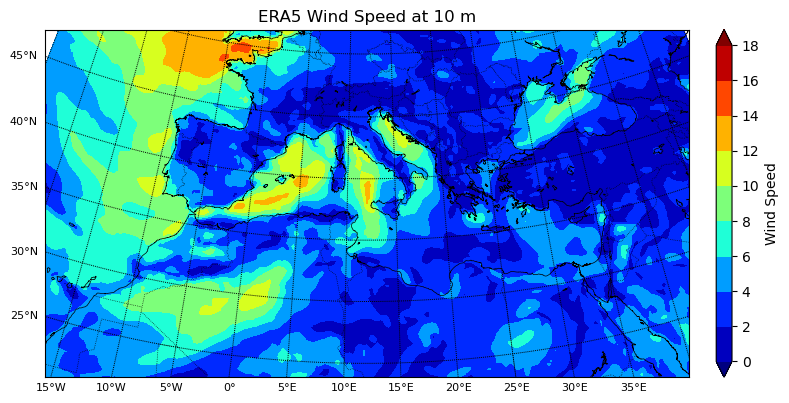

In [23]:
from matplotlib import cm
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(221)
parallels = np.arange(-90,90,5)
meridians = np.arange(0,360,5)
m_d01.drawcoastlines(color="black",linewidth=0.5)
m_d01.drawstates(linestyle="dotted")
m_d01.drawcountries(linestyle="dotted")
m_d01.drawparallels(parallels,labels=[1,0,0,0],fontsize=8,linewidth=.7)
m_d01.drawmeridians(meridians,labels=[0,0,0,1],fontsize=8,linewidth=.7)
x, y = m_d01(lons_era5,lats_era5) # compute map proj coordinates of the grid points
clevs=np.arange(0,20,2)
cs1 = m_d01.contourf(x,y,wind_speed_era5,clevs,cmap=plt.cm.jet,extend='both')
plt.colorbar(cs1, label= 'Wind Speed',fraction=0.023,pad=0.04)
fig.tight_layout()
plt.title('ERA5 Wind Speed at 10 m')


## Interpolate ERA5 fields to nested WRF domain [Single Test]:

In [6]:
for cyc_num in range(10,11):
    
    print('CYCLONE NUMBER: ', cyc_num)
    
    folder_era5_path = '/scratch/bidc/DCC/CYC_{:01d}/'.format(cyc_num)
    folder_wrf_path = '/scratch/bidc/DCC/medTRACK_{:04d}/'.format(cyc_num)

    # Select range of times for each Cyclone simulation:
    [files_d01,files_d02, earliest_date,latest_date] = get_cyclone_dates(folder_wrf_path, cyc_num)

    # Generate Dates every hour:
    date_list = generate_dates(earliest_date,latest_date)

    # Interpolating ERA5 fields to WRF nested domain:
    interp_method = 'cubic'
    [ ws_interp_era5,ws_interp_wrf_d01,wind_speed_wrf_d02,lat_wrf,lon_wrf ] = wspeed_ERA5Interpolation2wrf(files_d01,files_d02,date_list,interp_method)


CYCLONE NUMBER:  10
Earliest date: 2012-10-26 06:00:00
Latest date: 2012-10-29 23:00:00
time_step:  0 , date:  2012-10-26 06:00:00

time_step:  1 , date:  2012-10-26 07:00:00

time_step:  2 , date:  2012-10-26 08:00:00

time_step:  3 , date:  2012-10-26 09:00:00

time_step:  4 , date:  2012-10-26 10:00:00

time_step:  5 , date:  2012-10-26 11:00:00

time_step:  6 , date:  2012-10-26 12:00:00

time_step:  7 , date:  2012-10-26 13:00:00

time_step:  8 , date:  2012-10-26 14:00:00

time_step:  9 , date:  2012-10-26 15:00:00

time_step:  10 , date:  2012-10-26 16:00:00

time_step:  11 , date:  2012-10-26 17:00:00

time_step:  12 , date:  2012-10-26 18:00:00

time_step:  13 , date:  2012-10-26 19:00:00

time_step:  14 , date:  2012-10-26 20:00:00

time_step:  15 , date:  2012-10-26 21:00:00

time_step:  16 , date:  2012-10-26 22:00:00

time_step:  17 , date:  2012-10-26 23:00:00

time_step:  18 , date:  2012-10-27 00:00:00

time_step:  19 , date:  2012-10-27 01:00:00

time_step:  20 , date:

Text(0.5, 1.0, 'WRF_d02 Wind Speed at 10 m')

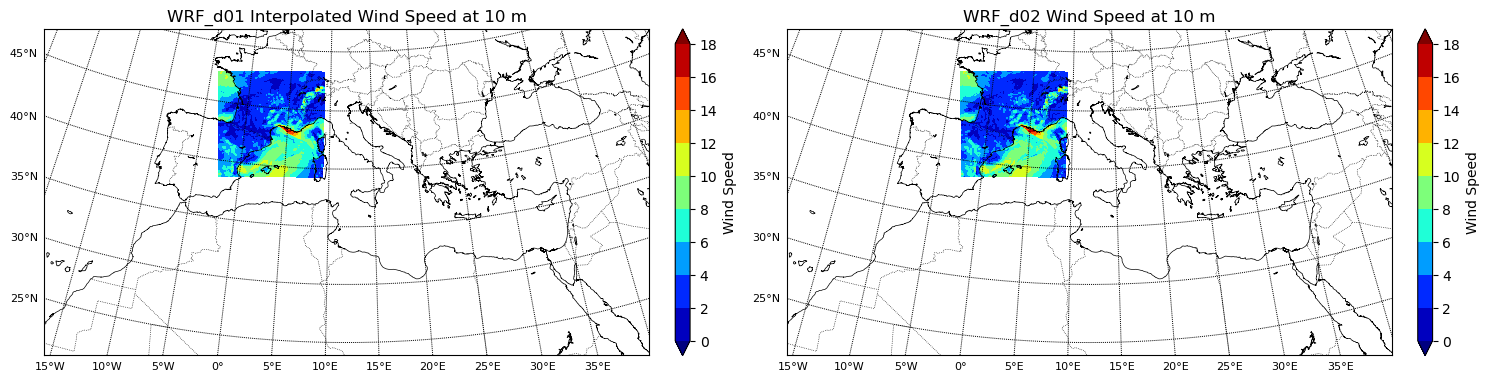

In [19]:
from matplotlib import cm
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(121)
parallels = np.arange(-90,90,5)
meridians = np.arange(0,360,5)
m_d01.drawcoastlines(color="black",linewidth=0.5)
m_d01.drawstates(linestyle="dotted")
m_d01.drawcountries(linestyle="dotted")
m_d01.drawparallels(parallels,labels=[1,0,0,0],fontsize=8,linewidth=.7)
m_d01.drawmeridians(meridians,labels=[0,0,0,1],fontsize=8,linewidth=.7)
x, y = m_d01(lon_wrf[10,:,:],lat_wrf[10,:,:]) # compute map proj coordinates of the grid points
clevs=np.arange(0,20,2)
cs1 = m_d01.contourf(x,y,ws_interp_wrf_d01[10,:,:],clevs,cmap=plt.cm.jet,extend='both')
plt.colorbar(cs1, label= 'Wind Speed',fraction=0.023,pad=0.04)
fig.tight_layout()
plt.title('WRF_d01 Interpolated Wind Speed at 10 m')
#
ax = fig.add_subplot(122)
parallels = np.arange(-90,90,5)
meridians = np.arange(0,360,5)
m_d01.drawcoastlines(color="black",linewidth=0.5)
m_d01.drawstates(linestyle="dotted")
m_d01.drawcountries(linestyle="dotted")
m_d01.drawparallels(parallels,labels=[1,0,0,0],fontsize=8,linewidth=.7)
m_d01.drawmeridians(meridians,labels=[0,0,0,1],fontsize=8,linewidth=.7)
#x, y = m_d01(lons_era5,lats_era5) # compute map proj coordinates of the grid points
clevs=np.arange(0,20,2)
cs1 = m_d01.contourf(x,y,wind_speed_wrf_d02[10,:,:],clevs,cmap=plt.cm.jet,extend='both')
plt.colorbar(cs1, label= 'Wind Speed',fraction=0.023,pad=0.04)
fig.tight_layout()
plt.title('WRF_d02 Wind Speed at 10 m')

In [92]:
filename_wrf_d01

'medCYC_0008_d01_2012-04-10_20_00_00'

In [98]:
cyc_num = 8

print('CYCLONE NUMBER: ', cyc_num)

folder_era5_path = '/scratch/bidc/DCC/CYC_{:01d}/'.format(cyc_num)
folder_wrf_path = '/scratch/bidc/DCC/medTRACK_{:04d}/'.format(cyc_num)

# Select range of times for each Cyclone simulation:
[files_d01,files_d02, earliest_date,latest_date] = get_cyclone_dates(folder_wrf_path, cyc_num)

# Generate Dates every hour:
date = generate_dates(earliest_date,latest_date)

#
# Opening ERA5 and WRF files:
#
filename_era5 = f"ERA5_AN_20120413_0800_sfc"
filename_wrf_d01 = f"medCYC_{cyc_num:04d}_d01_2012-04-13_08_00_00"
filename_wrf_d02 = f"medCYC_{cyc_num:04d}_d02_2012-04-13_08_00_00"
ds_era5 = xr.open_dataset(folder_era5_path + filename_era5, engine='cfgrib',backend_kwargs={'errors': 'ignore'})
ds_wrf_d01 = xr.open_dataset(folder_wrf_path + filename_wrf_d01)
ds_wrf_d02 = xr.open_dataset(folder_wrf_path + filename_wrf_d02)


# Initialize variables:
ds_wrf_d01 = xr.open_dataset(files_d01[0])
ds_wrf_d02 = xr.open_dataset(files_d02[0])
ydims_d01 = ds_wrf_d01.dims['south_north']
ydims_d02 = ds_wrf_d02.dims['south_north']
xdims_d01 = ds_wrf_d01.dims['west_east']
xdims_d02 = ds_wrf_d02.dims['west_east']
#print('xdims: ' ,xdims_d01, 'ydims: ', ydims_d01)
ws_interp_era5     = np.zeros(shape=(np.shape(date_list)[0],xdims_d02,ydims_d02))
ws_interp_wrf_d01  = np.zeros(shape=(np.shape(date_list)[0],xdims_d02,ydims_d02))
wind_speed_wrf_d01 = np.zeros(shape=(np.shape(date_list)[0],ydims_d01,xdims_d01))
wind_speed_wrf_d02 = np.zeros(shape=(np.shape(date_list)[0],xdims_d02,ydims_d02))
lat_wrf_d01 = np.zeros(shape=(np.shape(date_list)[0],ydims_d01,xdims_d01))
lon_wrf_d01 = np.zeros(shape=(np.shape(date_list)[0],ydims_d01,xdims_d01))
lat_wrf_d02 = np.zeros(shape=(np.shape(date_list)[0],xdims_d02,ydims_d02))
lon_wrf_d02 = np.zeros(shape=(np.shape(date_list)[0],xdims_d02,ydims_d02))


#
# Getting variables of interest from WRF (D01):
#

tt = 0

lat_wrf_d01[tt,:,:] = ds_wrf_d01['XLAT']
lon_wrf_d01[tt,:,:] = ds_wrf_d01['XLONG']
u10_wrf_d01 = ds_wrf_d01['U10']
v10_wrf_d01 = ds_wrf_d01['V10']
# Computing wind speed:
wind_speed_wrf_d01[tt,:,:] = np.sqrt(u10_wrf_d01**2 + v10_wrf_d01**2)
#
# Getting variables of interest from WRF (D02):
#
lat_wrf_d02[tt,:,:] = ds_wrf_d02['XLAT']
lon_wrf_d02[tt,:,:] = ds_wrf_d02['XLONG']
u10_wrf_d02 = ds_wrf_d02['U10']
v10_wrf_d02 = ds_wrf_d02['V10']
# Computing wind speed:
wind_speed_wrf_d02[tt,:,:] = np.sqrt(u10_wrf_d02**2 + v10_wrf_d02**2)
#
# Getting variables of interest from ERA5:
#
lat_era5 = ds_era5['latitude']
lon_era5 = ds_era5['longitude']
# Transform 1-dim lon_era5 and lat_era5 arrays to 2-dim arrays:
[lons_era5,lats_era5] = np.meshgrid(lon_era5,lat_era5)
u10_era5 = ds_era5['u10']
v10_era5 = ds_era5['v10']
# Computing wind speed:
wind_speed_era5 = np.sqrt(u10_era5**2 + v10_era5**2)
#
# Interpolate ERA5 fields to inner domain WRF:
#
grid_x = np.hstack(lon_wrf_d02[tt,:,:])
grid_y = np.hstack(lat_wrf_d02[tt,:,:])
grid_era5_x = np.hstack(lons_era5)
grid_era5_y = np.hstack(lats_era5)
grid = np.c_[grid_era5_x,grid_era5_y]
ws_era5 = np.hstack(wind_speed_era5)
# Cubic-Spline Interpolation:
wind_speed_interp_era5 = griddata(grid, ws_era5, (grid_x, grid_y), method=interp_method)
ws_interp_era5[tt,:,:] = np.reshape(wind_speed_interp_era5,(np.shape(wind_speed_wrf_d02[tt,:,:])[0],np.shape(wind_speed_wrf_d02[tt,:,:])[1]))
#
# Interpolate WRF (D01) fields to inner domain WRF:
#
grid_x = np.hstack(lon_wrf_d02[tt,:,:])
grid_y = np.hstack(lat_wrf_d02[tt,:,:])
grid_wrf_x = np.hstack(lon_wrf_d01[tt,:,:])
grid_wrf_y = np.hstack(lat_wrf_d01[tt,:,:])
grid = np.c_[grid_wrf_x,grid_wrf_y]
ws_wrf_d01 = np.hstack(wind_speed_wrf_d01[tt,:,:])
# Cubic-Spline Interpolation:
wind_speed_interp_wrf_d01 = griddata(grid, ws_wrf_d01, (grid_x, grid_y), method=interp_method)
ws_interp_wrf_d01[tt,:,:] = np.reshape(wind_speed_interp_wrf_d01,(np.shape(wind_speed_wrf_d02[tt,:,:])[0],np.shape(wind_speed_wrf_d02[tt,:,:])[1]))


CYCLONE NUMBER:  8
Earliest date: 2012-04-12 12:00:00
Latest date: 2012-04-14 20:00:00


(233, 295)
(360, 360)


Text(0.5, 1.0, 'Copernicus Obs Wind Speed at 10 m')

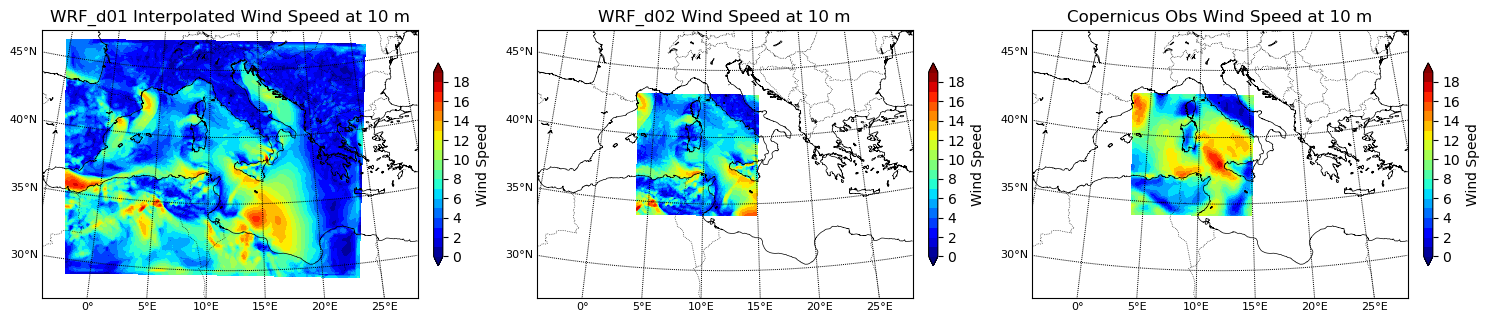

In [107]:
tt = 20

# Loading dataset with pickle:
folder_obs_path = '/hpcperm/bidc/Project_Spgrflao/Paper/Plots/Copernicus_Obs/'
file_name       = folder_obs_path+'wspeed_Copernicus_Interpolation2WRF_Cyc_{:04d}_binary'.format(cyc_num)
binary_file     = open(file_name,"rb")
dataset_obs     = pickle.load(binary_file)
ws_obs      = dataset_obs['ws_interp_copernicus'][tt,:,:]

ds_wrf_d01 = xr.open_dataset(files_d01[tt])
ds_wrf_d02 = xr.open_dataset(files_d02[tt])

# Computing wind speed D01:
lat_wrf_d02 = ds_wrf_d02['XLAT'][0,:,:].values
lon_wrf_d02 = ds_wrf_d02['XLONG'][0,:,:].values
u10_wrf_d02 = ds_wrf_d02['U10']
v10_wrf_d02 = ds_wrf_d02['V10']
wind_speed_wrf_d02 = np.sqrt(u10_wrf_d02**2 + v10_wrf_d02**2)[0,:,:]

# Computing wind speed D02:
lat_wrf_d01 = ds_wrf_d01['XLAT'][0,:,:].values
lon_wrf_d01 = ds_wrf_d01['XLONG'][0,:,:].values
u10_wrf_d01 = ds_wrf_d01['U10']
v10_wrf_d01 = ds_wrf_d01['V10']
wind_speed_wrf_d01 = np.sqrt(u10_wrf_d01**2 + v10_wrf_d01**2)[0,:,:]

print(np.shape(lat_wrf_d01))
print(np.shape(lat_wrf_d02))

from matplotlib import cm
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(131)
parallels = np.arange(-90,90,5)
meridians = np.arange(0,360,5)
m_d01.drawcoastlines(color="black",linewidth=0.5)
m_d01.drawstates(linestyle="dotted")
m_d01.drawcountries(linestyle="dotted")
m_d01.drawparallels(parallels,labels=[1,0,0,0],fontsize=8,linewidth=.7)
m_d01.drawmeridians(meridians,labels=[0,0,0,1],fontsize=8,linewidth=.7)
x, y = m_d01(lon_wrf_d01,lat_wrf_d01) # compute map proj coordinates of the grid points
clevs=np.arange(0,20,1)
cs1 = m_d01.contourf(x,y,wind_speed_wrf_d01,clevs,cmap=plt.cm.jet,extend='both')
plt.colorbar(cs1, label= 'Wind Speed',fraction=0.023,pad=0.04)
fig.tight_layout()
plt.title('WRF_d01 Interpolated Wind Speed at 10 m')
#
ax = fig.add_subplot(132)
parallels = np.arange(-90,90,5)
meridians = np.arange(0,360,5)
m_d01.drawcoastlines(color="black",linewidth=0.5)
m_d01.drawstates(linestyle="dotted")
m_d01.drawcountries(linestyle="dotted")
m_d01.drawparallels(parallels,labels=[1,0,0,0],fontsize=8,linewidth=.7)
m_d01.drawmeridians(meridians,labels=[0,0,0,1],fontsize=8,linewidth=.7)
x, y = m_d01(lon_wrf_d02,lat_wrf_d02) # compute map proj coordinates of the grid points
#clevs=np.arange(0,20,2)
cs1 = m_d01.contourf(x,y,wind_speed_wrf_d02,clevs,cmap=plt.cm.jet,extend='both')
plt.colorbar(cs1, label= 'Wind Speed',fraction=0.023,pad=0.04)
fig.tight_layout()
plt.title('WRF_d02 Wind Speed at 10 m')
#
ax = fig.add_subplot(133)
parallels = np.arange(-90,90,5)
meridians = np.arange(0,360,5)
m_d01.drawcoastlines(color="black",linewidth=0.5)
m_d01.drawstates(linestyle="dotted")
m_d01.drawcountries(linestyle="dotted")
m_d01.drawparallels(parallels,labels=[1,0,0,0],fontsize=8,linewidth=.7)
m_d01.drawmeridians(meridians,labels=[0,0,0,1],fontsize=8,linewidth=.7)
x, y = m_d01(lon_wrf_d02,lat_wrf_d02) # compute map proj coordinates of the grid points
#clevs=np.arange(0,20,2)
cs1 = m_d01.contourf(x,y,ws_obs,clevs,cmap=plt.cm.jet,extend='both')
plt.colorbar(cs1, label= 'Wind Speed',fraction=0.023,pad=0.04)
fig.tight_layout()
plt.title('Copernicus Obs Wind Speed at 10 m')

## Interpolate ERA5 fields to nested WRF domain:

In [ ]:
#cyc_num = 150
#cyc_num = 12

for cyc_num in range(1,201):
    
    print('CYCLONE NUMBER: ', cyc_num)
    
    folder_era5_path = '/scratch/bidc/DCC/CYC_{:01d}/'.format(cyc_num)
    folder_wrf_path = '/scratch/bidc/DCC/medTRACK_{:04d}/'.format(cyc_num)

    # Select range of times for each Cyclone simulation:
    [files_d01,files_d02, earliest_date,latest_date] = get_cyclone_dates(folder_wrf_path, cyc_num)

    # Generate Dates every hour:
    date_list = generate_dates(earliest_date,latest_date)

    # Interpolating ERA5 fields to WRF nested domain:
    interp_method = 'cubic'
    [ ws_interp_era5,ws_interp_wrf_d01,wind_speed_wrf_d02,lat_wrf,lon_wrf ] = wspeed_ERA5Interpolation2wrf(files_d01,files_d02,date_list,interp_method)



    # Save dataset using pickle:
    file_name_as = 'wspeed_ERA5_Interpolation2WRF_Cyc_{:04d}_binary'.format(cyc_num)
    data_to_save = {'ws_interp_era5': ws_interp_era5, 'ws_interp_wrf_d01': ws_interp_wrf_d01, 'wind_speed_wrf_d02': wind_speed_wrf_d02, 'lat': lat_wrf, 'lon': lon_wrf}
    binary = open(file_name_as,"wb")
    pickle.dump(data_to_save,binary)
    binary.close()
    # del(binary)

    # Load dataset using pickle:
    # binary_file = open(file_name_as,"rb")
    # dataset     = pickle.load(binary_file)

#### Plotting Figure:

time index:  0
time index:  1


/perm/bidc/conda/envs/Emmanouil_Project/lib/python3.8/site-packages/matplotlib/contour.py:1483: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/perm/bidc/conda/envs/Emmanouil_Project/lib/python3.8/site-packages/matplotlib/contour.py:1484: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())


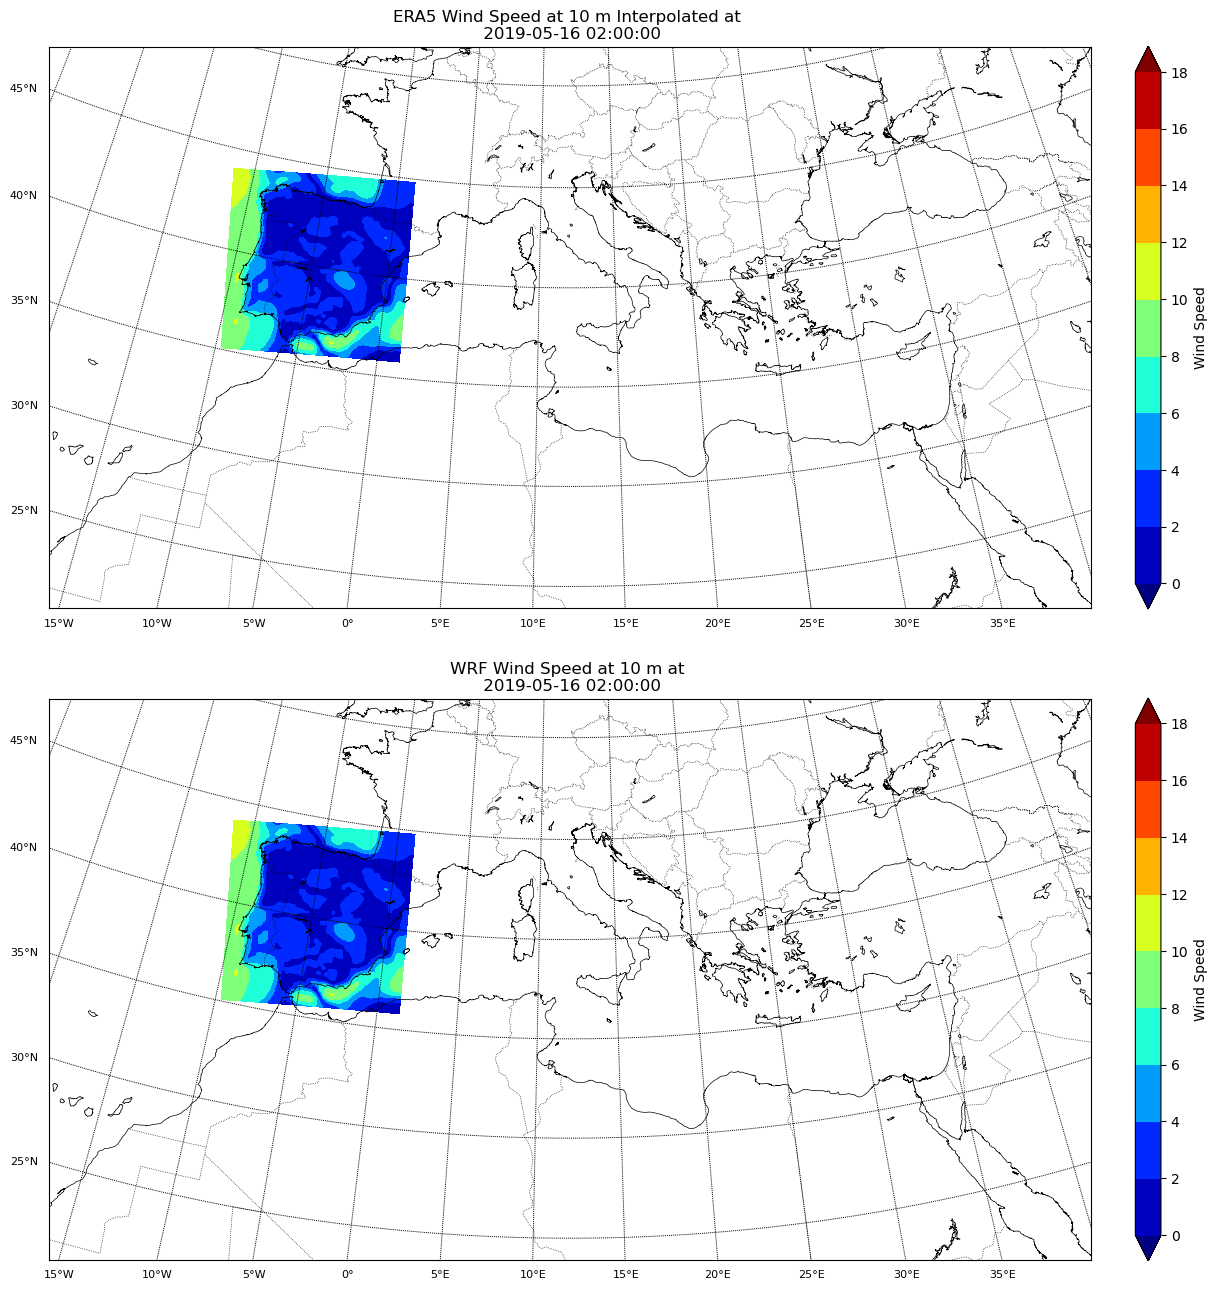

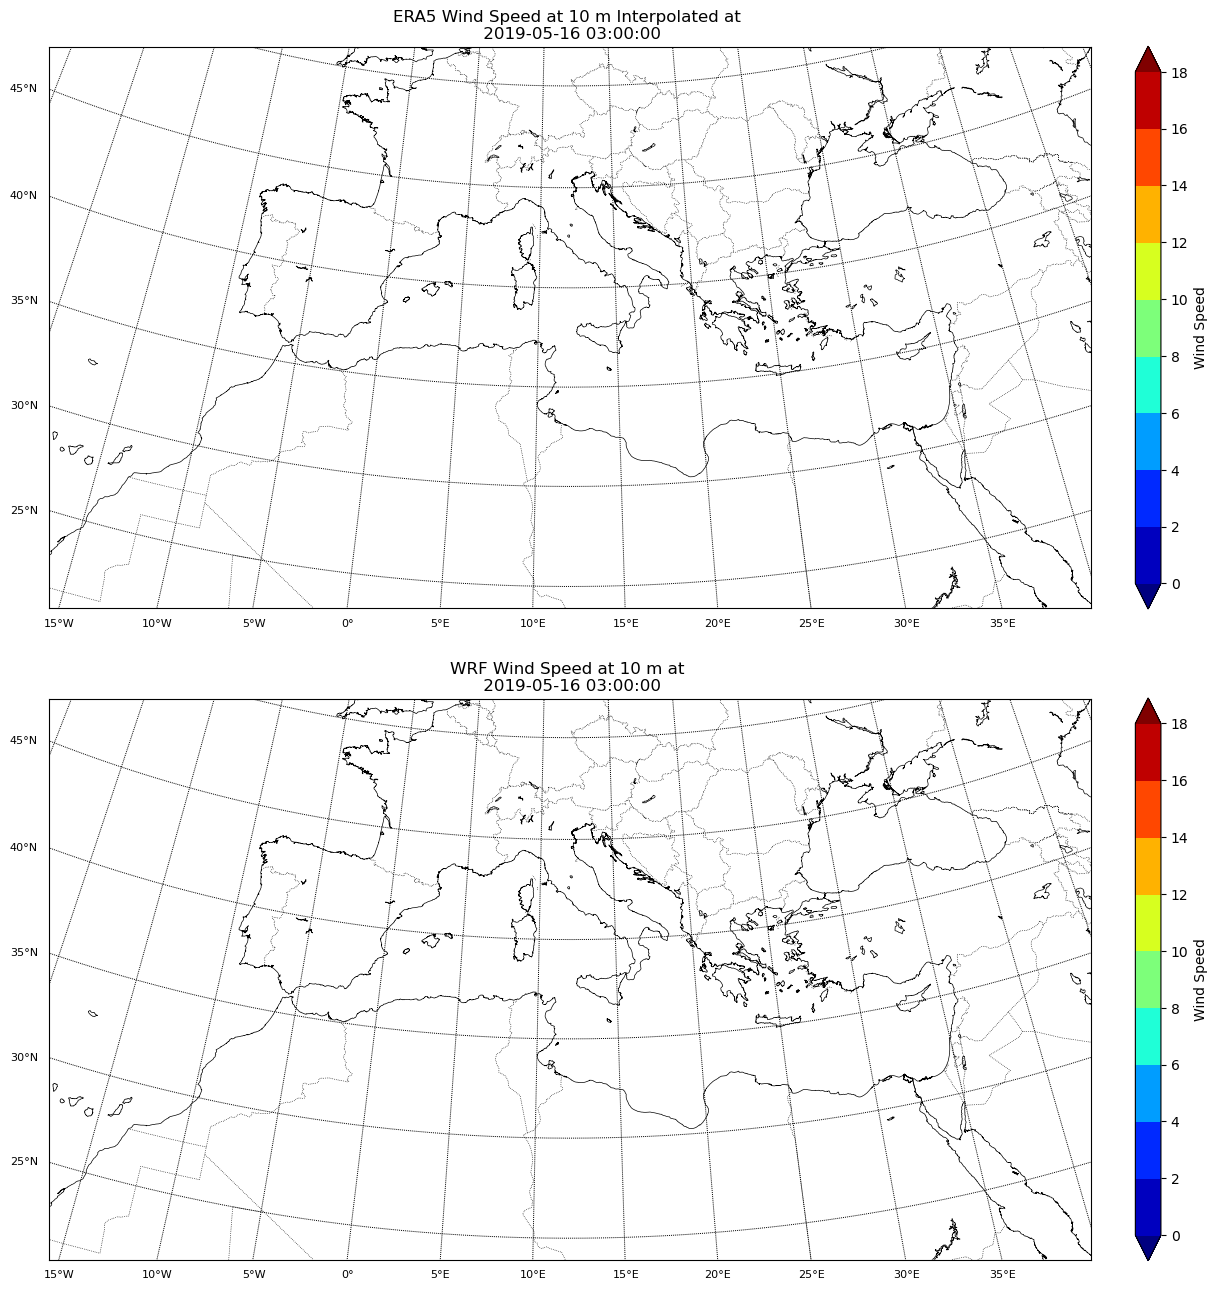

In [ ]:
#for t_index in range(0,np.shape(lon_wrf)[0]):
for t_index in range(0,2):   
    print('time index: ',t_index)
    plot_ERA5vsWRF(t_index,date_list,lon_wrf,lat_wrf,ws_interp_era5,wind_speed_wrf_d02,m_d01)